# Examples to analyze area lipid and thickness from the NMRlipids databank

This notebook exemplifies how to:
1. Plot area per lipid from binary mixtures as function of lipid composition
2. Plot correlation between membrane thickness and area
3. Plot correlation between form factor minima and area per lipid
4. Plot correlation between form factor minima and membrane thickness

# Initialize NMRlipids databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import MDAnalysis
import urllib.request
import yaml
from scipy.interpolate import interpn
import pandas as pd
import seaborn as sn
import scipy.stats

sys.path.insert(1, '../../Databank/Scripts/BuildDatabank/')
from databankLibrary import download_link, lipids_dict, databank

path = '../../Databank/Data/Simulations/'
db_data = databank(path)
systems = db_data.get_systems()

def calcArea(system):
    APL = CalcAreaPerMolecule(system)
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid/(2*APL)

def CalcAreaPerMolecule(system):
    APLpath = system['path'] + 'apl.json'
    try:
        f = open(APLpath)
        APLdata = json.load(f)
        sumAPL = 0
        sumIND = 0
        for i,j in APLdata.items():
            sumAPL += j
            sumIND += 1
        APL = sumAPL/sumIND
        return(APL)
    except:
        print('apl.json not found from' + system['path'])
        
def GetThickness(system):
    ThicknessPath = system['path'] + 'thickness.json'
    try:
        f = open(ThicknessPath)
        thickness = json.load(f)
        return(thickness)
    except:
        return 0
        #print('thickness.json not found from' + system['path'])

def GetNlipids(system):
    Nlipid = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            Nlipid += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    return Nlipid

        
def getWaterPermeation(system):
    filename = system['path'].replace('../../Databank/Data/Simulations/','../../DataBankManuscript/Data/MD-PERMEATION/')
    filename = filename + 'Counting_events.txt'
    try:
        with open(filename) as f:
            last_line = f.readlines()[-1]
        events = float(last_line.split()[1])
        time = float(last_line.split()[0])
        
        APL = CalcAreaPerMolecule(system)
        Nlipids = GetNlipids(system)
        
        #print(events, APL, Nlipids)
        #print(events/(time*10**(-3)*APL*0.01*Nlipids*0.5))
        
        # Number of events per time and area (1/(micros*nm^2))
        return events/(time*10**(-3)*APL*0.01*Nlipids*0.5)
        
    except:
        pass

    
    
def GetFormFactorMin(system):
    FormFactorPath = system['path'] + 'FormFactor.json'
    #try:
    f = open(FormFactorPath)
    FormFactor = json.load(f)
    min = 1000
    iprev = FormFactor[0][1]
    iprevD = 0
    minX = []
    for i in FormFactor:
        iD = i[1]-iprev
        if iD > 0 and iprevD < 0 and i[0] > 0.1:
            minX.append(i[0])
        iprevD = i[1]-iprev
        iprev = i[1]
        
    return(minX)

def plotFF(FormFactor, color, linewidth):
    x = []
    y= []
    for i in FormFactor:
        x.append(i[0])
        y.append(i[1])
    plt.plot(x,y,color = color, linewidth = linewidth)

def plotAPLS(MATRIX,ADDITIVE):
    ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".dat"):
                #print(filepath)
                df=pd.read_csv(filepath, sep = " ", header =  None, names=["fraction", "area", "DOI"])
                df2 = df.groupby('fraction')['area'].mean().apply(lambda x: '{:.2f}'.format(x))
                df2.to_csv(filepath, sep = " ", header =  None)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    x = [float(line.split()[0]) for line in lines]
                    y = [float(line.split()[1]) for line in lines]
                    #print(filepath,x,y)
                    if len(set(x)) > 1:
                        plt.plot(x,y,label = filename,marker='o',linewidth=2, markersize=12,linestyle='dashed')
    #plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
    plt.legend(loc='best', fontsize=10)
    plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX, fontsize=15)
    plt.ylabel('Area per molecule (Å$^2$)', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(ResultDir + 'APL.pdf')
    plt.show()

def plotThickness(MATRIX,ADDITIVE):
    ResultDir = './resultsThickness/' + ADDITIVE + '_in_' + MATRIX + '/'
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".dat"):
                df=pd.read_csv(filepath, sep = " ", header =  None, names=["fraction", "area", "DOI"])
                df2 = df.groupby('fraction')['area'].mean().apply(lambda x: '{:.2f}'.format(x))
                df2.to_csv(filepath, sep = " ", header =  None)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    x = [float(line.split()[0]) for line in lines]
                    y = [float(line.split()[1]) for line in lines]
                    #print(filepath,x,y)
                    if len(set(x)) > 1:
                        plt.plot(x,y,label = filename,marker='o')
    plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
    plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
    plt.ylabel('Thickness (nm)')
    plt.show()

def plotWaterPermeation(MATRIX,ADDITIVE):
    ResultDir = './resultsWaterPermeation/' + ADDITIVE + '_in_' + MATRIX + '/'
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".dat"):
                df=pd.read_csv(filepath, sep = " ", header =  None, names=["fraction", "area", "DOI"])
                df2 = df.groupby('fraction')['area'].mean().apply(lambda x: '{:.2f}'.format(x))
                df2.to_csv(filepath, sep = " ", header =  None)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    x = [float(line.split()[0]) for line in lines]
                    y = [float(line.split()[1]) for line in lines]
                    #print(filepath,x,y)
                    if len(set(x)) > 1:
                        plt.plot(x,y,label = filename,marker='o')
    plt.legend(bbox_to_anchor=(1.5, 1),loc='upper right')
    plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX)
    plt.ylabel('Water permeation [events/(micros*nm^2)]')
    plt.show()

    
    
def interpolateAPL(LIPID1,LIPID2,LIPID3,FFfile,prop):
    values = {}
    
    ResultDir = './results' + prop + '/' + LIPID2 + '_in_' + LIPID1 + '/'
    #print(ResultDir)
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:                
            filepath = subdir + os.sep + filename
            #print(filename)
            if filename == FFfile:
                print(filepath)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    for line in lines:
                        LIPID2comp = float(line.split()[0])
                        LIPID1comp = 100-float(line.split()[0])
                        LIPID3comp = 0
                        apl = float(line.split()[1])
                        #print(filepath)
                        #if len(LIPID1comp) > 1:
                        #points = (LIPID1comp,LIPID2comp,LIPID3comp)
                        values[LIPID1comp,LIPID2comp,LIPID3comp] = apl
    
    
    ResultDir = './results' + prop + '/' + LIPID3 + '_in_' + LIPID2 + '/'
    #print(ResultDir)
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:                
            filepath = subdir + os.sep + filename
            #print(filename)
            if filename == FFfile:
                print(filepath)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    for line in lines:
                        LIPID3comp = float(line.split()[0])
                        LIPID2comp = 100-float(line.split()[0])
                        LIPID1comp = 0
                        apl = float(line.split()[1])
                        #print(filepath)
                        #if len(LIPID1comp) > 1:
                        #points = (LIPID1comp,LIPID2comp,LIPID3comp)
                        values[LIPID1comp,LIPID2comp,LIPID3comp] = apl

                        
    ResultDir = './results' + prop + '/' + LIPID3 + '_in_' + LIPID1 + '/'
    #print(ResultDir)
    for subdir, dirs, files in os.walk(ResultDir):
        for filename in files:
            filepath = subdir + os.sep + filename
            #print(filename)
            if filename == FFfile:
                print(filepath)
                with open(filepath) as APLfile:
                    lines = APLfile.readlines()#[1:]
                    for line in lines:
                        LIPID1comp = float(line.split()[0])
                        LIPID3comp = 100-float(line.split()[0])
                        LIPID2comp = 0
                        apl = float(line.split()[1])
                        #print(filepath)
                        #if len(LIPID1comp) > 1:
                        #points = (LIPID1comp,LIPID2comp,LIPID3comp)
                        values[LIPID1comp,LIPID2comp,LIPID3comp] = apl
                  
    return(values)


def averageOrderParameters(system):
    
    DataBankPath = '../../Databank/Data/'
    path = DataBankPath + system['path']
    
    sn1sum = 0
    sn1count = 0
    sn2sum = 0
    sn2count = 0
    
    for lipid in system['COMPOSITION']:
        if lipid in lipids_dict and not 'CHOL' in lipid:
            OPpathSIM = path + lipid + 'OrderParameters.json'
            with open(OPpathSIM) as json_file:
                OPsim = json.load(json_file)
    
            for key in OPsim:
                if 'M_G1C' in key:
                    sn1sum += float(OPsim[key][0][0])
                    sn1count += 1
                elif 'M_G2C' in key:
                    sn2sum += float(OPsim[key][0][0])
                    sn2count += 1
                    
    return sn1sum/sn1count, sn2sum/sn2count



/home/samuli/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


# Create correlation matrix

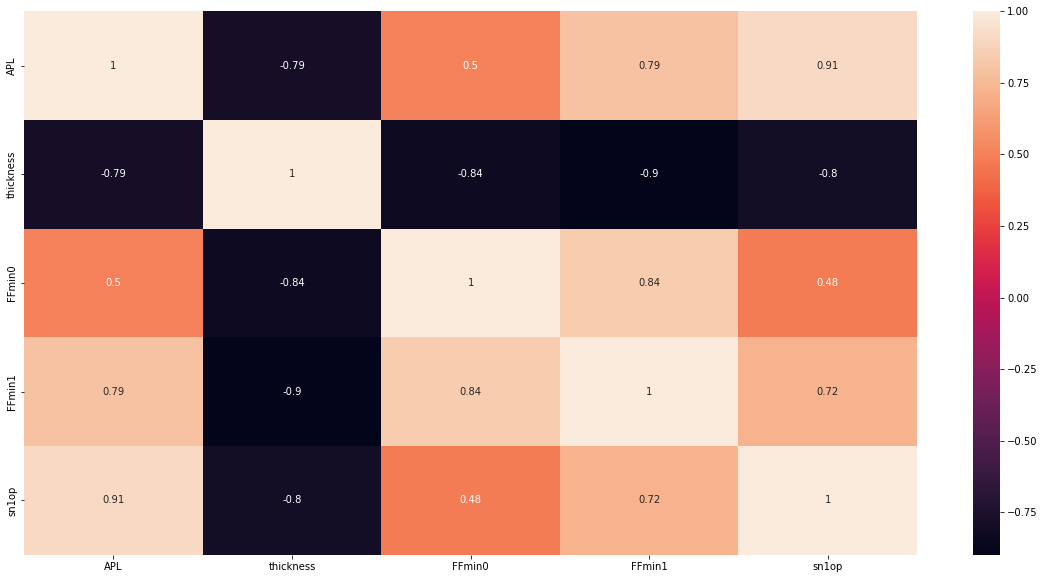

In [2]:

ID = 0
CorrelationMatrix = {}

for system in systems:
    try:
        FFmins = GetFormFactorMin(system)
    except:
        FFmins = [0,0,0]
    APLvalue = CalcAreaPerMolecule(system)
    if APLvalue == None:
        continue
    ThicknessValue = GetThickness(system)
    area = calcArea(system)
    #print(FFmins,APLvalue,ThicknessValue)
    
    try:
        tailOPavg = averageOrderParameters(system)
    except:
        continue
    
    if FFmins[1] == 0 or ThicknessValue == 0: 
        continue
    
    #if FFmins[1] > 0.48: 
    #    continue
       
    #if ThicknessValue < 3:
    #    continue
    
    ID += 1
    CorrelationMatrix[ID] = {
        'APL': APLvalue, 
        'thickness': ThicknessValue,
        'FFmin0': FFmins[0],
        'FFmin1' : FFmins[1],
        #'FFmin3' : FFmins[2],
        'sn1op' : tailOPavg[0],
        #'sn2op' : tailOPavg[1],
        #'area' : area
    }
    
    
data = {}
for prop in CorrelationMatrix[1]:
    if prop == 'path':
        continue
    data[prop] = []

for ID in CorrelationMatrix:
    for prop in CorrelationMatrix[ID]:
        if prop == 'path':
            continue
        data[prop].append(CorrelationMatrix[ID][prop])
        #print(ID,prop)

columns = []
for i in data:
    columns.append(i)

df = pd.DataFrame(data,columns=columns)

corrMatrix = df.corr()
#print (corrMatrix)
plt.figure(figsize = (20,10))
sn.heatmap(corrMatrix, annot=True)

plt.show()

# Area per lipid vs. thickness

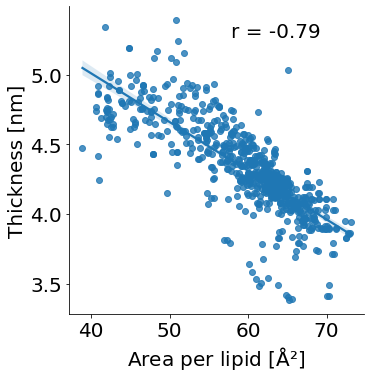

In [7]:
sn.lmplot(x="APL", y="thickness", data=df);
x = data['APL']
y = data['thickness']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.55, 0.9), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Area per lipid [Å$²$]',  fontsize = 20)
ax.set_ylabel('Thickness [nm]',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/APLvsTHICKNESS.pdf')


# Area per lipid vs sn-1 order

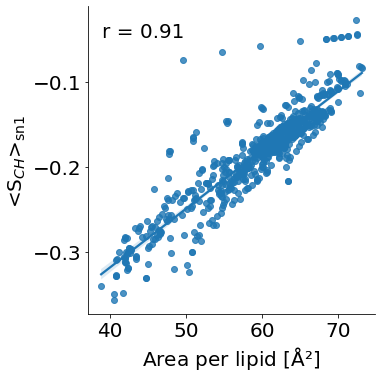

In [8]:
sn.lmplot(x="APL", y="sn1op", data=df);
x = data['APL']
y = data['sn1op']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Area per lipid [Å$²$]',  fontsize = 20)
ax.set_ylabel('<S$_{CH}$>$_{\mathrm{sn1}}$',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/sn1OPvsAPL.pdf')

# Area per lipid vs first form factor minima

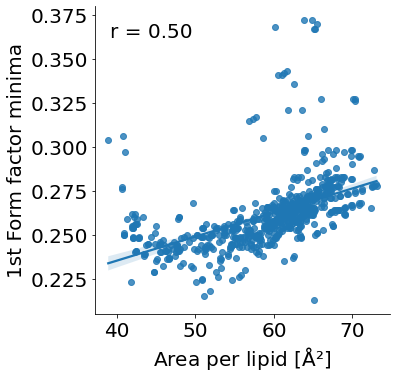

In [4]:
sn.lmplot(x="APL", y="FFmin0", data=df);
x = data['APL']
y = data['FFmin0']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Area per lipid [Å$²$]',  fontsize = 20)
ax.set_ylabel('1st Form factor minima',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/FFmin0vsAPL.pdf')


# Area per lipid vs. second form factor minima

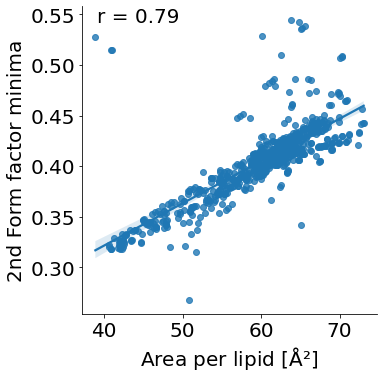

In [5]:
sn.lmplot(x="APL", y="FFmin1", data=df);
x = data['APL']
y = data['FFmin1']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.95), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Area per lipid [Å$²$]',  fontsize = 20)
ax.set_ylabel('2nd Form factor minima',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/FFmin1vsAPL.pdf')


# Thickness vs first form factor minima

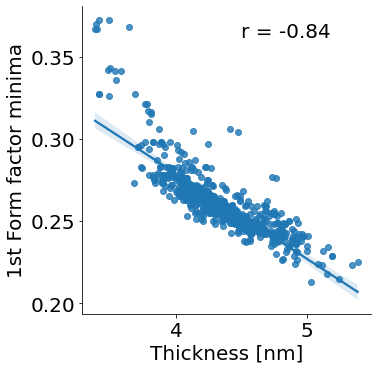

In [9]:
sn.lmplot(x="thickness", y="FFmin0", data=df);
x = data['thickness']
y = data['FFmin0']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.55, 0.9), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Thickness [nm]',  fontsize = 20)
ax.set_ylabel('1st Form factor minima',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/FFmin0vsTHICKNESS.pdf')


# Thickness vs second minima of form factor

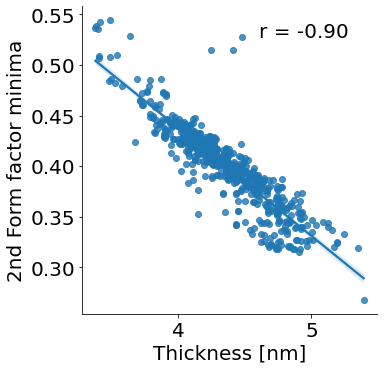

In [6]:
sn.lmplot(x="thickness", y="FFmin1", data=df);
x = data['thickness']
y = data['FFmin1']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.6, 0.9), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Thickness [nm]',  fontsize = 20)
ax.set_ylabel('2nd Form factor minima',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/FFmin1vsTHICKNESS.pdf')


# Thickness vs. sn-1 order

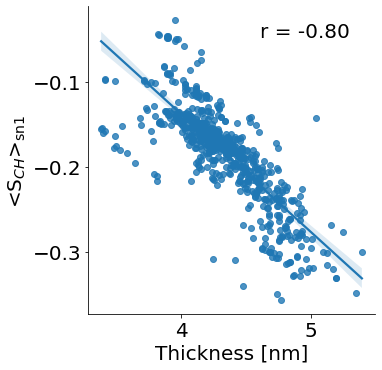

In [7]:
sn.lmplot(x="thickness", y="sn1op", data=df);
x = data['thickness']
y = data['sn1op']
r, p = scipy.stats.pearsonr(x, y)
p_stars = ''
#if p <= 0.05:
#    p_stars = '*'
#if p <= 0.01:
#    p_stars = '**'
#if p <= 0.001:
#    p_stars = '***'

ax = plt.gca()
ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.6, 0.9), xycoords=ax.transAxes, fontsize = 20)
ax.set_xlabel('Thickness [nm]',  fontsize = 20)
ax.set_ylabel('<S$_{CH}$>$_{\mathrm{sn1}}$',  fontsize = 20)
ax.tick_params(axis='x', labelsize = 20)
ax.tick_params(axis='y', labelsize = 20)
plt.savefig('../figures/sn1opvsTHICKNESS.pdf')


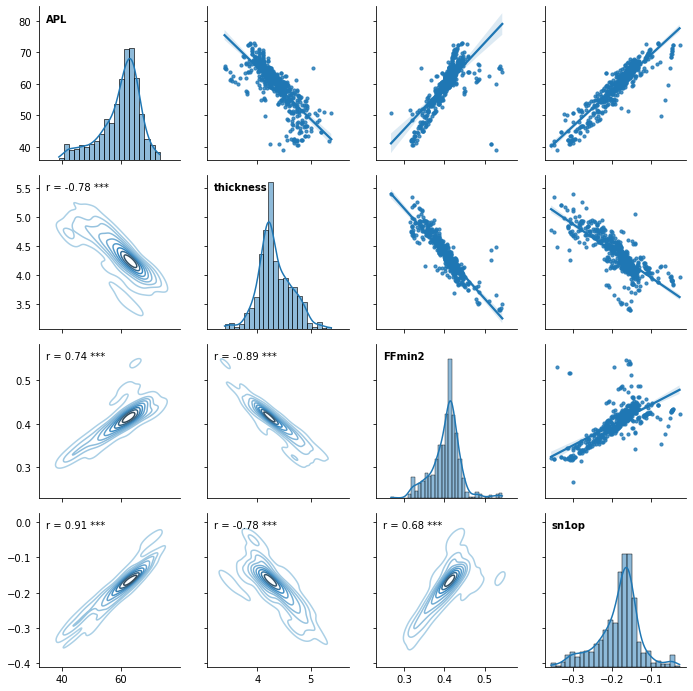

In [16]:
#df = sn.load_dataset(data,columns=columns)
#sn.PairGrid(df, palette=['red'])

from scipy import stats

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)


def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

g = sn.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
g.map_upper(sn.regplot, scatter_kws={'s':10})
g.map_diag(sn.histplot, kde= True)
g.map_diag(annotate_colname)
g.map_lower(sn.kdeplot, cmap='Blues_d')
g.map_lower(corrfunc)
# Remove axis labels, as they're in the diagonals.
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
g
#g.figure.savefig("correlations.pdf")
g.savefig("correlations.pdf")

# Create area per lipid data of mixtures containing MATRIX or ADDITIVE lipids, or both

mkdir: cannot create directory ‘./results/POPE_in_POPC/’: File exists
mkdir: cannot create directory ‘./resultsThickness/POPE_in_POPC/’: File exists
mkdir: cannot create directory ‘./resultsWaterPermeation/POPE_in_POPC/’: File exists
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./results/POPE_in_POPC/T310K_CHARMM36_(center_of_mass_removed_independently_for_upper_leaflet,_lower_leaflet_and_water+ions).dat -o ./results/POPE_in_POPC/T310K_CHARMM36_(center_of_mass_removed_independently_for_upper_leaflet,_lower_leaflet_and_water+ions).dat'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `sort -n -k 1 ./resultsThickness/POPE_in_POPC/T310K_CHARMM36_(center_of_mass_removed_independently_for_upper_leaflet,_lower_leaflet_and_water+ions).dat -o ./resultsThickness/POPE_in_POPC/T310K_CHARMM36_(center_of_mass_removed_independently_for_upper_leaflet,_lower_leaflet_and_water+ions).dat'
/bin/bash: -c: line 0: syn

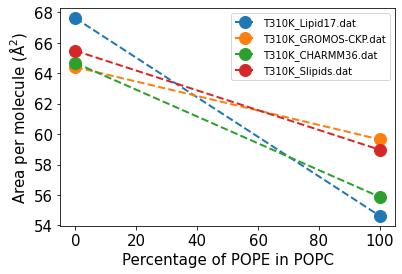

In [31]:
## You can change these to define the MATRIX and ADDITIVE lipids
MATRIX = 'POPC'
ADDITIVE = 'POPE'



ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
ResultDirThickness = './resultsThickness/' + ADDITIVE + '_in_' + MATRIX + '/'
ResultDirWaterPermeation = './resultsWaterPermeation/' + ADDITIVE + '_in_' + MATRIX + '/'
!mkdir {ResultDir}
!rm {ResultDir}/*
!mkdir {ResultDirThickness}
!rm {ResultDirThickness}/*
!mkdir {ResultDirWaterPermeation}
!rm {ResultDirWaterPermeation}/*



apl_DICT = {}
for system in systems:
    
    try:
        NADDITIVE = np.sum(system['COMPOSITION'][ADDITIVE]['COUNT'])
    except:
        NADDITIVE = 0    
    
    try:
        NMATRIX = np.sum(system['COMPOSITION'][MATRIX]['COUNT'])
    except:
        NMATRIX = 0
    
    NLIPIDS = 0
    for molecule in system['COMPOSITION']:
        if molecule in lipids_dict:
            NLIPIDS += np.sum(system['COMPOSITION'][molecule]['COUNT'])
    
    if (NMATRIX + NADDITIVE) != NLIPIDS:
        #print('skipped')
        continue
    
    try:
        if system['WARNINGS']['NOWATER']:
            continue
    except:
        pass
    
    if system['COMPOSITION']['SOL']['COUNT'] < 20*NLIPIDS:
        #print('skipped')
        continue
    
    if system['DOI'] == '10.5281/zenodo.1293813':
        continue
    
    #print(system['TEMPERATURE'])
    if system['TEMPERATURE'] > 310 or system['TEMPERATURE'] < 310:
        continue
    
    
    APL = CalcAreaPerMolecule(system)
    Thickness = GetThickness(system)
    waterPermeation = getWaterPermeation(system)
    
    
    try:
        CaConcentration = system['COMPOSITION']['CAL']['COUNT'] * 55.5 / system['COMPOSITION']['SOL']['COUNT']
    except:
        CaConcentration = 0
    
    lipidsRATIO = 100*NADDITIVE / NLIPIDS
    forcefield = system.get('FF')
    temperature = round(system.get('TEMPERATURE'))
    DOI = system.get('DOI')
    apl_DICT[lipidsRATIO,CaConcentration,forcefield,temperature,DOI] = APL
    #apl_DICT[lipidsRATIO,CaConcentration,forcefield,DOI] = APL
   
    OutFileName = ResultDir + 'T' + str(temperature) + 'K'
    OutFileNameThickness = ResultDirThickness + 'T' + str(temperature) + 'K'
    OutFileNameWaterPermeation = ResultDirWaterPermeation + 'T' + str(temperature) + 'K'
    
    try:
        NSOD = np.sum(system['COMPOSITION']['SOD']['COUNT'])
    except:
        NSOD = 0    
        
    try:
        NCLA = np.sum(system['COMPOSITION']['CLA']['COUNT'])
    except:
        NCLA = 0    
    
    if NCLA > 0 and not 'DHMDMAB' in ADDITIVE:
        #print('skipped')
        continue
        
    if ('POPG' in ADDITIVE or 'POPS' in ADDITIVE) and NADDITIVE != NSOD:
        #print('skipped')
        continue
    
    try:
        FFname = system['FF'].replace(" ","_")
        FFname = FFname.replace("/","_")
        OutFileName = OutFileName + '_' + FFname +'.dat'
        OutFileNameThickness = OutFileNameThickness + '_' + FFname +'.dat'
        OutFileNameWaterPermeation = OutFileNameWaterPermeation + '_' + FFname +'.dat'
    except:
        continue
    #print(FFname)

    if APL:
        outfile=open(OutFileName,'a')
        outfile.write(str(round(lipidsRATIO,3)) + " " + str(APL) + " " + str(system['DOI']))
        outfile.write('\n')
        outfile.close()
        !sort -n -k 1 {OutFileName} -o {OutFileName}

    if Thickness:
        outfile=open(OutFileNameThickness,'a')
        outfile.write(str(round(lipidsRATIO,3)) + " " + str(Thickness) + " " + str(system['DOI']))
        outfile.write('\n')
        outfile.close()
        !sort -n -k 1 {OutFileNameThickness} -o {OutFileNameThickness}
    if waterPermeation:
        outfile=open(OutFileNameWaterPermeation,'a')
        outfile.write(str(round(lipidsRATIO,3)) + " " + str(waterPermeation) + " " + str(system['DOI']))
        outfile.write('\n')
        outfile.close()
        !sort -n -k 1 {OutFileNameWaterPermeation} -o {OutFileNameWaterPermeation}
        
plotAPLS(MATRIX,ADDITIVE)

0


<BarContainer object of 2 artists>

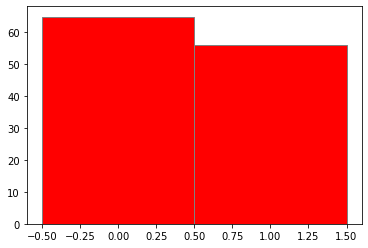

In [29]:
ResultDir = './results/' + ADDITIVE + '_in_' + MATRIX + '/'
LipidFracDict = {0.0: 0, 100.0: 1}
print(LipidFracDict[0.0])

filepath = ResultDir + 'T310K_CHARMM36.dat'

barWidth = 1.0

with open(filepath) as APLfile:
    lines = APLfile.readlines()#[1:]
    x = [float(LipidFracDict[float(line.split()[0])]) for line in lines]
    y = [float(line.split()[1]) for line in lines]
plt.bar(x, y, color ='r', width = barWidth,
            edgecolor ='grey', label ='IT')
    #plt.legend(bbox_to_anchor=(1.05, 1),loc='best')
    #plt.legend(loc='best', fontsize=10)
    #plt.xlabel('Percentage of ' + ADDITIVE + ' in ' + MATRIX, fontsize=15)
    #plt.ylabel('Area per molecule (Å)^2', fontsize=15)
    #plt.xticks(fontsize=15)
    #plt.yticks(fontsize=15)
    #plt.savefig(ResultDir + 'APL.pdf')
    #plt.show()


In [7]:
for system in systems:
    FF = system['FF']
    #print(FF)
    if 'Lipid17' in FF:
        #print(system)
        if 'POPC' in system['COMPOSITION'].keys():
            print(system['COMPOSITION'].keys(), system['TEMPERATURE'], system['DOI'], system['ID'])
        #if 'POPC' in system['COMPOSITION'].keys():
        #    print(system['COMPOSITION'].keys(), system['TEMPERATURE'])

dict_keys(['POPC', 'POPG', 'SOL', 'SOD']) 298.0 10.5281/zenodo.3857816 503
dict_keys(['POPC', 'POPS', 'SOL', 'SOD']) 298.0 10.5281/zenodo.1487761 188
dict_keys(['POPC', 'POPG', 'SOL', 'CAL', 'CLA', 'SOD']) 298.0 10.5281/zenodo.3833725 217
dict_keys(['POPC', 'SOL']) 310.0 10.5281/zenodo.3237657 386
dict_keys(['POPC', 'POPS', 'SOL', 'CAL', 'CLA', 'SOD']) 298.0 10.5281/zenodo.1487761 424
dict_keys(['POPS', 'POPC', 'SOL', 'SOD', 'POT', 'CLA']) 298.0 10.5281/zenodo.1487895 287
dict_keys(['POPC', 'SOD', 'CLA', 'SOL']) 310.0 10.5281/zenodo.2574959 92
dict_keys(['POPC', 'POPS', 'SOL', 'CAL', 'CLA', 'SOD']) 298.0 10.5281/zenodo.1487761 177
dict_keys(['POPS', 'POPC', 'SOL', 'SOD', 'CLA']) 298.0 10.5281/zenodo.1487906 314
dict_keys(['POPC', 'POPS', 'SOL', 'CAL', 'CLA', 'SOD']) 298.0 10.5281/zenodo.1487761 313
dict_keys(['POPC', 'POPS', 'SOL', 'CAL', 'CLA', 'SOD']) 298.0 10.5281/zenodo.1487761 48
dict_keys(['POPS', 'POPC', 'SOL', 'SOD', 'POT', 'CLA']) 298.0 10.5281/zenodo.1487895 540
dict_keys(['P

# Plot area per lipid data of MATRIX and ADDITIVE mixtures 

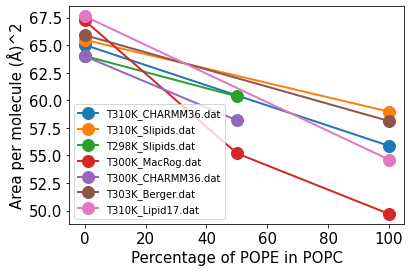

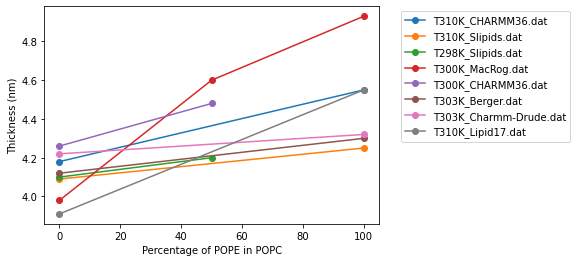

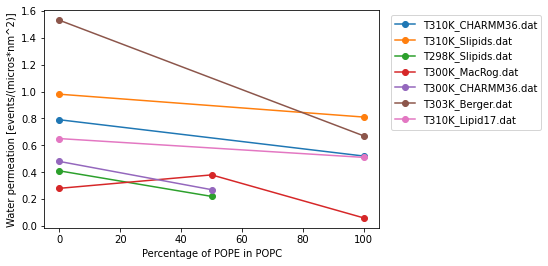

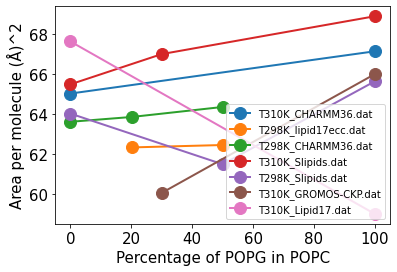

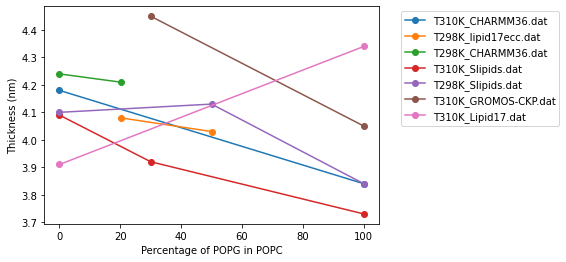

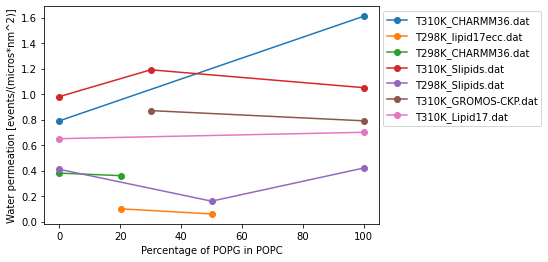

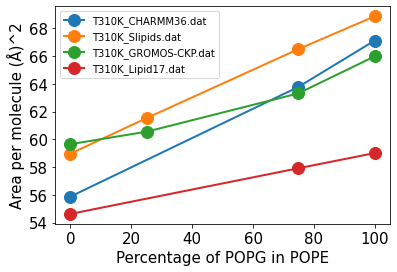

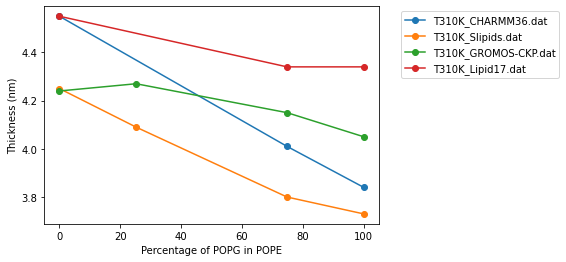

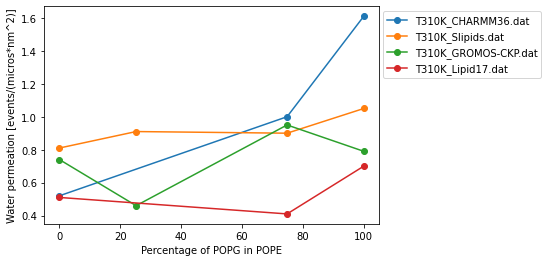

In [11]:
plotAPLS('POPC','POPE')
plotThickness('POPC','POPE')
plotWaterPermeation('POPC','POPE')

plotAPLS('POPC','POPG')
plotThickness('POPC','POPG')
plotWaterPermeation('POPC','POPG')

plotAPLS('POPE','POPG')
plotThickness('POPE','POPG')
plotWaterPermeation('POPE','POPG')

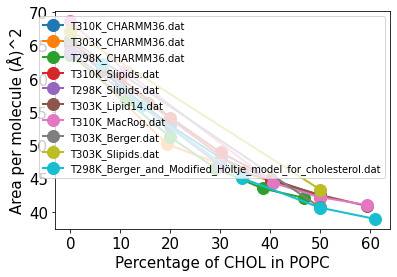

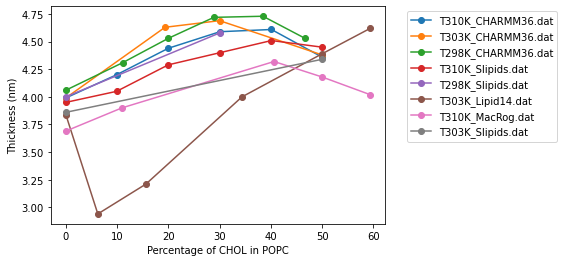

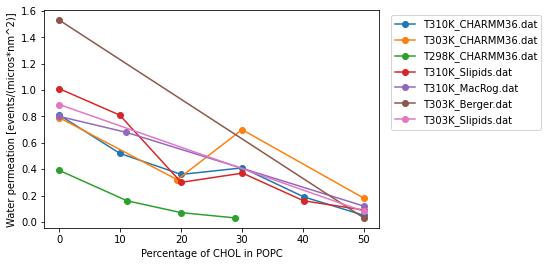

In [25]:
plotAPLS('POPC','CHOL')
plotThickness('POPC','CHOL')
plotWaterPermeation('POPC','CHOL')

No handles with labels found to put in legend.


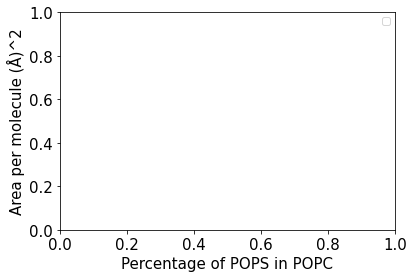

No handles with labels found to put in legend.


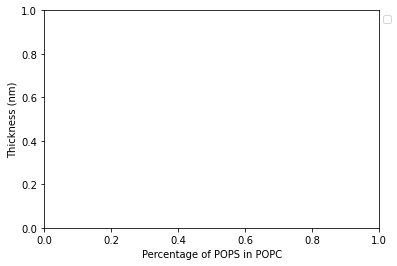

No handles with labels found to put in legend.


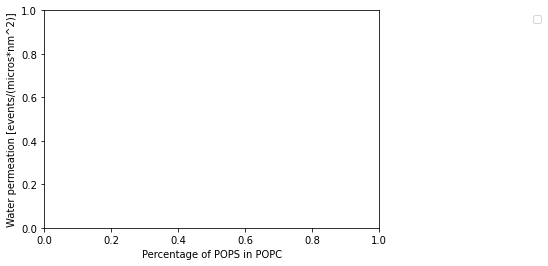

In [26]:
plotAPLS('POPC','POPS')
plotThickness('POPC','POPS')
plotWaterPermeation('POPC','POPS')

# Predict area per lipid for bacterial membrane mimic with linear regression model


In [38]:
prop = 'WaterPermeation/' #'WaterPermeation'
IP = interpolateAPL('POPC','POPE','POPG','T310K_Lipid17.dat',prop)
print(IP)

points = np.zeros((len(IP),3))
values = np.zeros(len(IP))

ind = 0
for results in IP:
    points[ind][0] = results[0]
    points[ind][1] = results[1]
    points[ind][2] = results[2] 
    values[ind] = IP[results]
    ind += 1
    
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(points, values)

print("\n Predicted ", prop, ": ", *reg.predict(np.array([[10, 45,45]])))

./resultsWaterPermeation//POPE_in_POPC//T310K_Lipid17.dat
./resultsWaterPermeation//POPG_in_POPE//T310K_Lipid17.dat
./resultsWaterPermeation//POPG_in_POPC//T310K_Lipid17.dat
{(100.0, 0.0, 0): 0.58, (0.0, 100.0, 0): 0.37, (0, 0.0, 100.0): 0.95}

 Predicted  WaterPermeation/ :  0.652


# Plot correlation between membrane thickness and area per molecule


apl.json not found from../../Databank/Data/Simulations/0fe/cf2/0fecf2da1be19236b6c47c26b2b1ea2306246c47/0fecf2da1be19236b6c47c26b2b1ea2306246c47/


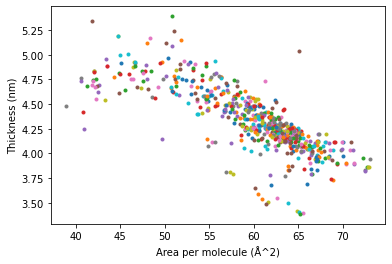

In [2]:
APL = []
Thickness = []
for system in systems:
    APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if APLvalue and ThicknessValue:
        plt.plot(APLvalue,ThicknessValue,'.')
    plt.xlabel('Area per molecule (Å^2)')
    plt.ylabel('Thickness (nm)')
    #plt.ylim([2.5, 5.5])

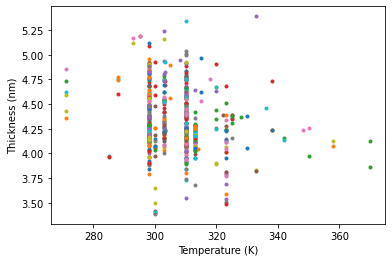

In [29]:
Temperature = []
Thickness = []
for system in systems:
    TEMPERATUREvalue = system['TEMPERATURE']
    ThicknessValue = GetThickness(system)
    if TEMPERATUREvalue and ThicknessValue:
        plt.plot(TEMPERATUREvalue,ThicknessValue,'.')
    plt.xlabel('Temperature (K)')
    plt.ylabel('Thickness (nm)')

# Correlation between area per lipid and the first three minima of form factors


40.99144524112455 0.515 ../../Databank/Data/Simulations/019/eb8/019eb8d7691998587faa1e618272a564ff9e697e/577a6cc9d00effd20baf941d520a23d91701352d/
40.83615503306391 0.515 ../../Databank/Data/Simulations/0e9/f5e/0e9f5e64ad7244273eb2f544966ba7dd606fbbb1/2578273ee378997849b0bec8b8b3414797cdce73/
apl.json not found from../../Databank/Data/Simulations/0fe/cf2/0fecf2da1be19236b6c47c26b2b1ea2306246c47/0fecf2da1be19236b6c47c26b2b1ea2306246c47/
38.90298447802505 0.528 ../../Databank/Data/Simulations/9a1/605/9a16054f3de88c6236c869a48b7ba22a4560c031/1ee911c0a7597ddccc6a2f88e6de0103731df881/


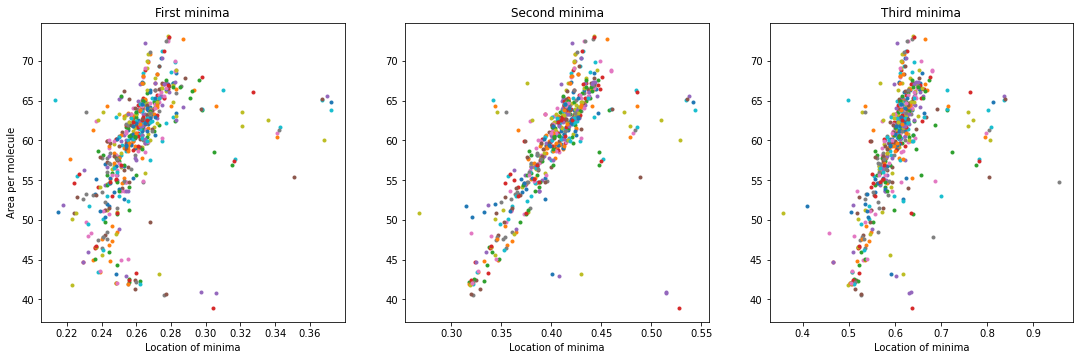

In [3]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("First minima")
ax2.set_title("Second minima")
ax3.set_title("Third minima")
ax1.set_ylabel("Area per molecule")
ax1.set_xlabel("Location of minima")
ax2.set_xlabel("Location of minima")
ax3.set_xlabel("Location of minima")

#ax1.set_ylim([0, 1])
#ax2.set_ylim([0, 1])
#ax3.set_ylim([0, 1])

for system in systems:
    #if system['TEMPERATURE'] != 310:
    #    continue
    try:
        FFmins = GetFormFactorMin(system)
    except:
        pass
    APLvalue = CalcAreaPerMolecule(system)
    try: 
        if APLvalue < 45 and FFmins[1] > 0.5:
            print(APLvalue, FFmins[1], system['path'])
    except:
        pass
    if APLvalue == None:
        continue
    ThicknessValue = GetThickness(system)
    ax1.plot(FFmins[0],APLvalue,'.')
    ax2.plot(FFmins[1],APLvalue,'.')
    ax3.plot(FFmins[2],APLvalue,'.')
    #plt.plot(APLvalue,FFmins[i],'.')


# Correlation between thickness and the first three minima of form factors


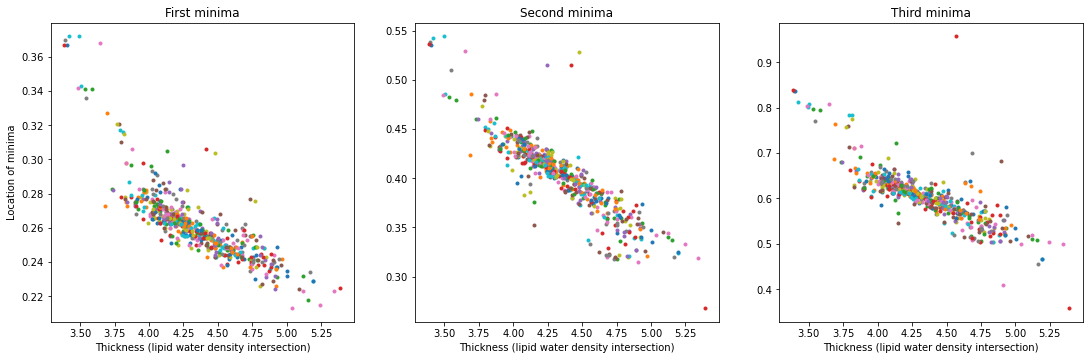

In [4]:
fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("First minima")
ax2.set_title("Second minima")
ax3.set_title("Third minima")
ax1.set_ylabel("Location of minima")
ax1.set_xlabel("Thickness (lipid water density intersection)")
ax2.set_xlabel("Thickness (lipid water density intersection)")
ax3.set_xlabel("Thickness (lipid water density intersection)")


#ax1.set_ylim([0, 1])
#ax2.set_ylim([0, 1])
#ax3.set_ylim([0, 1])

for system in systems:
    #print(system['path'])
    try:
        FFmins = GetFormFactorMin(system)
    except:
        pass
        #print('Failed')
    #APLvalue = CalcAreaPerMolecule(system)
    ThicknessValue = GetThickness(system)
    if ThicknessValue:
        ax1.plot(ThicknessValue,FFmins[0],'.')
        ax2.plot(ThicknessValue,FFmins[1],'.')
        ax3.plot(ThicknessValue,FFmins[2],'.')
        #plt.plot(ThicknessValue,FFmins[0],'.')

# Plot correlation between average order parameters, thickness and area per lipid

apl.json not found from../../Databank/Data/Simulations/0fe/cf2/0fecf2da1be19236b6c47c26b2b1ea2306246c47/0fecf2da1be19236b6c47c26b2b1ea2306246c47/


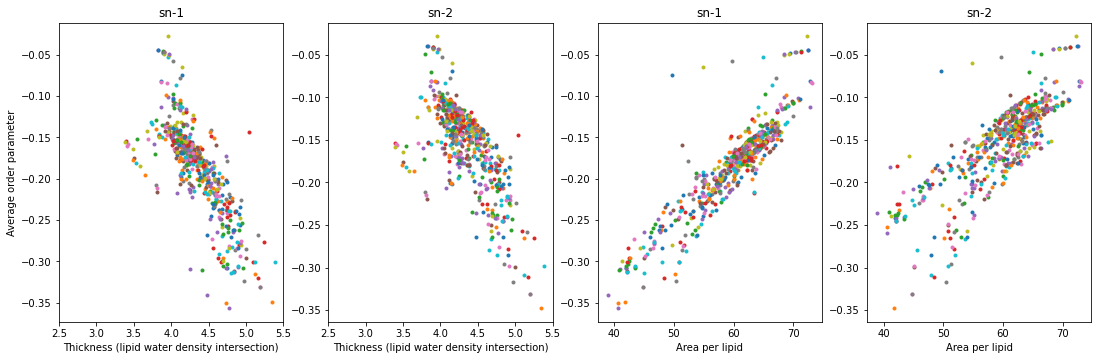

In [6]:
fig1, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4)
fig1.set_size_inches(18.5, 5.5)
ax1.set_title("sn-1")
ax2.set_title("sn-2")
ax3.set_title("sn-1")
ax4.set_title("sn-2")
ax1.set_ylabel("Average order parameter")
ax1.set_xlabel("Thickness (lipid water density intersection)")
ax2.set_xlabel("Thickness (lipid water density intersection)")
ax3.set_xlabel("Area per lipid")
ax4.set_xlabel("Area per lipid")


ax1.set_xlim([2.5, 5.5])
ax2.set_xlim([2.5, 5.5])
#ax3.set_ylim([0, 1])

for system in systems:
    try:
        tailOPavg = averageOrderParameters(system)
    except:
        continue
    ThicknessValue = GetThickness(system)
    APLvalue = CalcAreaPerMolecule(system)
    if APLvalue == None:
        continue
    if ThicknessValue:
        ax1.plot(ThicknessValue,tailOPavg[0],'.')
        ax2.plot(ThicknessValue,tailOPavg[1],'.')
        ax3.plot(APLvalue,tailOPavg[0],'.')
        ax4.plot(APLvalue,tailOPavg[1],'.')
        #plt.plot(ThicknessValue,FFmins[0],'.')


In [18]:
scipy.stats.pearsonr(data['FFmin2'],data['sn1op'])

(0.6844713265767434, 8.211555906928923e-85)

In [11]:
scipy.stats.spearmanr(data['FFmin2'],data['sn1op'])

SpearmanrResult(correlation=0.7767919232937193, pvalue=3.3288087428686036e-123)

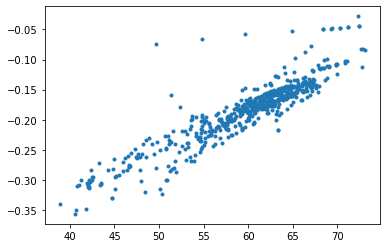

In [12]:
plt.plot(data['APL'],data['sn1op'],".")

/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/osollila/.conda/envs/py39/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

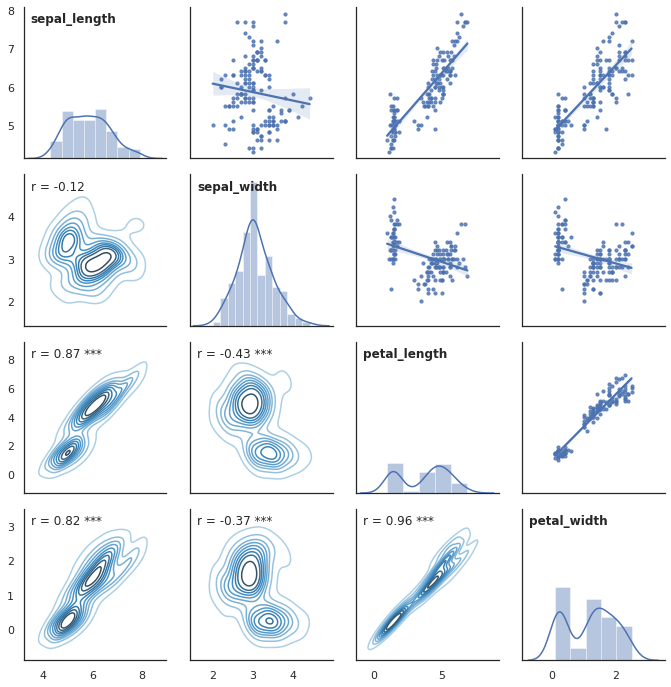

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style='white')
iris = sns.load_dataset('iris')

def corrfunc(x, y, **kws):
  r, p = stats.pearsonr(x, y)
  p_stars = ''
  if p <= 0.05:
    p_stars = '*'
  if p <= 0.01:
    p_stars = '**'
  if p <= 0.001:
    p_stars = '***'
  ax = plt.gca()
  ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

def annotate_colname(x, **kws):
  ax = plt.gca()
  ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def cor_matrix(df):
  g = sns.PairGrid(df, palette=['red'])
  # Use normal regplot as `lowess=True` doesn't provide CIs.
  g.map_upper(sns.regplot, scatter_kws={'s':10})
  g.map_diag(sns.distplot)
  g.map_diag(annotate_colname)
  g.map_lower(sns.kdeplot, cmap='Blues_d')
  g.map_lower(corrfunc)
  # Remove axis labels, as they're in the diagonals.
  for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')
  return g

cor_matrix(iris)


In [44]:
iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [43]:
data['FFmin2']

[0.387,
 0.39300000000000007,
 0.435,
 0.41700000000000004,
 0.515,
 0.387,
 0.38800000000000007,
 0.391,
 0.39,
 0.41300000000000003,
 0.38,
 0.43300000000000005,
 0.318,
 0.3940000000000001,
 0.43100000000000005,
 0.44300000000000006,
 0.403,
 0.35200000000000004,
 0.544,
 0.344,
 0.435,
 0.515,
 0.34700000000000003,
 0.43,
 0.43300000000000005,
 0.405,
 0.452,
 0.44300000000000006,
 0.441,
 0.44800000000000006,
 0.44900000000000007,
 0.41300000000000003,
 0.34500000000000003,
 0.40800000000000003,
 0.43300000000000005,
 0.42700000000000005,
 0.402,
 0.4040000000000001,
 0.4040000000000001,
 0.39,
 0.41700000000000004,
 0.325,
 0.34700000000000003,
 0.41100000000000003,
 0.42300000000000004,
 0.3940000000000001,
 0.40700000000000003,
 0.44700000000000006,
 0.36700000000000005,
 0.446,
 0.37300000000000005,
 0.42600000000000005,
 0.43,
 0.35700000000000004,
 0.542,
 0.375,
 0.42400000000000004,
 0.405,
 0.41200000000000003,
 0.41700000000000004,
 0.41700000000000004,
 0.43,
 0.4150000

[0.29700000000000004, 0.515, 0.6340000000000001, 0.8290000000000001]
[0.37200000000000005, 0.544, 0.802, 0.877]
[0.306, 0.515, 0.631, 0.8370000000000001]
[0.37200000000000005, 0.542, 0.8130000000000002, 0.845]
[0.31, 0.485, 0.7140000000000001, 0.755, 0.9570000000000001]
[0.341, 0.48200000000000004, 0.7980000000000002, 0.9180000000000001]
[0.30400000000000005, 0.528, 0.636, 0.877]
[0.306, 0.48600000000000004, 0.7160000000000001, 0.8680000000000001]
[0.37, 0.538, 0.8370000000000001]
[0.35100000000000003, 0.48900000000000005, 0.805, 0.892]
[0.36700000000000005, 0.535, 0.8360000000000001]
[0.343, 0.48600000000000004, 0.8080000000000002, 0.92]
[0.336, 0.51, 0.77]
[0.342, 0.48400000000000004, 0.804, 0.92]
[0.36700000000000005, 0.536, 0.8380000000000001]
[0.327, 0.48600000000000004, 0.763, 0.782]
[0.36800000000000005, 0.529, 0.807, 0.89]


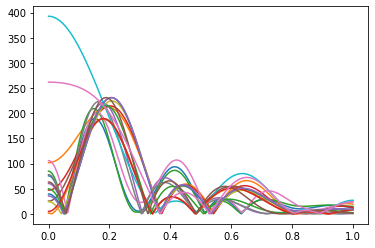

In [97]:
for system in systems:
    try:
        FFmins = GetFormFactorMin(system)
    except:
        continue
    FormFactorPath = system['path'] + 'FormFactor.json'
    f = open(FormFactorPath)
    FormFactor = json.load(f)
    if FFmins[1] > 0.48:
        plotFF(FormFactor)
        print(FFmins)
        #print(system['COMPOSITION'])
        #print(system['TEMPERATURE'])
    #print(FormFactor)

1024
1024
256
256
64
64
64
256
64
256
256
1024
1024
1024
64
1024
256
64


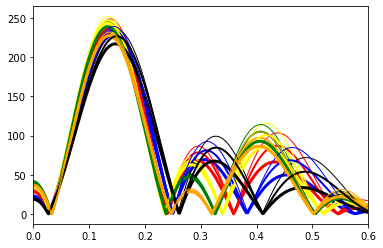

In [139]:
colors = {0: 'black', 0.25: 'red', 0.125: 'blue', 0.625: 'green', 0.40625: 'yellow', 0.875:'orange'}
widths = {64: 1, 256: 2, 1024: 3}

for system in systems:
    FormFactorPath = system['path'] + 'FormFactor.json'
    try: 
        f = open(FormFactorPath)
    except:
        continue
    FormFactor = json.load(f)
    #print(system)
    #try:
        #if 'Javanainen' in system['AUTHORS_CONTACT'] and 'CHOL' in system['COMPOSITION'].keys()  and 'POPC' in system['COMPOSITION'].keys():
    if '10.5281/zenodo.5767451' in system['DOI']:
        try:
            Nchol = np.sum(system['COMPOSITION']['CHOL']['COUNT'])
        except:
            Nchol = 0
        Npopc = np.sum(system['COMPOSITION']['POPC']['COUNT'])
        ratio = Nchol/Npopc
        print(Npopc)
        plotFF(FormFactor, colors[ratio], widths[Npopc])
        #print(FFmins)
            #print(system['COMPOSITION'])
            #print(system['TEMPERATURE'])
            #print(FormFactor)       
    ##except:
    #  continue
    #plt.show()
    plt.xlim([0,0.6])